# Entrenamiento - datos y limpieza

Ahora que ya tenemos todo el código necesario para un transformer vamos a entrenar uno, pero primero tenemos que descargarnos un dataset y hacerle una pequeña limpieza

## Datos

Como hemos dicho en el notebook anterior vamos a usar el dataset [opus100](https://huggingface.co/datasets/Maximofn/opus100) del inglés al español (`en-es`)

In [6]:
from datasets import load_dataset

dataset_repo = "Maximofn/opus100"
opus100_train = load_dataset(dataset_repo, split='train')
opus100_val = load_dataset(dataset_repo, split='validation')
opus100_test = load_dataset(dataset_repo, split='test')

Vamos a analizar un poco el dataset, primero veamos el tipo de dato

In [7]:
print(f"dataset train type: {type(opus100_train)}")
print(f"dataset validation type: {type(opus100_val)}")
print(f"dataset test type: {type(opus100_test)}")

dataset train type: <class 'datasets.arrow_dataset.Dataset'>
dataset validation type: <class 'datasets.arrow_dataset.Dataset'>
dataset test type: <class 'datasets.arrow_dataset.Dataset'>


Vamos a ver cómo son

In [8]:
print(f"dataset train: {opus100_train}")
print(f"dataset validation: {opus100_val}")
print(f"dataset test: {opus100_test}")

dataset train: Dataset({
    features: ['translation'],
    num_rows: 1000000
})
dataset validation: Dataset({
    features: ['translation'],
    num_rows: 2000
})
dataset test: Dataset({
    features: ['translation'],
    num_rows: 2000
})


Como vemos tienen una `feature` llamada `translation` que es la que nos interesa, vamos a ver cómo son

In [9]:
print(f"train translation: {opus100_train[0]['translation']}")
print(f"validation translation: {opus100_val[0]['translation']}")
print(f"test translation: {opus100_test[0]['translation']}")

train translation: {'en': "It was the asbestos in here, that's what did it!", 'es': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'}
validation translation: {'en': "I don't even remember what the fight was about.", 'es': 'No recuerdo por qué fue la pelea.'}
test translation: {'en': 'If your country produced ODS for this purpose, please enter the amount so produced in column 6 on Data Form\xa03.”', 'es': 'Si su país produjo SAO para estos usos, sírvase anotar en la columna 6 del formulario de datos 3 la cantidad correspondiente”.'}


Como vemos es un diccionario con dos claves `en` y `es` que son las traducciones de inglés y español respectivamente, vamos a ver cómo son

Terminemos ya con un ejemplo

In [10]:
import numpy.random as random
idx = random.randint(0, len(opus100_train))
opus100_train[idx]["translation"]

{'en': 'The Council further wished to reiterate its conviction that a reduction in tensions between the Governments of the Sudan and Chad is essential for lasting regional security and to call on both Governments to abide by their obligations under the Dakar Agreement of 13 March 2008, the Tripoli Agreement of 8 February 2006 and other bilateral agreements.',
 'es': 'Además el Consejo deseaba reiterar su convencimiento de que era imprescindible reducir las tensiones entre los Gobiernos del Sudán y el Chad para que exista una seguridad duradera en la región, y exhortar a ambos Gobiernos a que cumplan las obligaciones contraídas en virtud del Acuerdo de Dakar de 13 de marzo de 2008, el Acuerdo de Trípoli de 8 de febrero de 2006 y otros acuerdos bilaterales.'}

## Limpieza

Siempre en un problema de lenguaje hay que hacer una limpieza de los datos, porque podemos encontrarnos frases malas que no van a aportar, sino que solo van a empeorar el modelo

Antes de hacer la limpieza veamos otra vez las longitudes de los datasets

In [8]:
print(f"len dataset train: {len(opus100_train)}")
print(f"len dataset validation: {len(opus100_val)}")
print(f"len dataset test: {len(opus100_test)}")

len dataset train: 1000000
len dataset validation: 2000
len dataset test: 2000


Vamos a hacer una limpieza muy sencilla, vamos a crear una lista de caracteres `extraños` que no suelen estar en una frase del inglés o del español y vamos a eliminar esas frases. Para buscar esos caracteres nos vamos a una [tabla ASCII](https://www.rapidtables.com/code/text/ascii-table.html) y buscamos caracteres que creamos que no suelen estar en una frase del inglés o del español.

En mi caso son estos

In [9]:
ilegal_chars = ['¢', '¤', '¥', '¦', '§', '¨', '©', '¬', '¯', '¶', '¸', 'À', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'È', 'Ê', 'Ë', 'Ì', 'Î', 'Ï', 'Ð', 'Ò', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Û', 'Ý', 'Þ', 'ß', 'à', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'ê', 'ë', 'ì', 'î', 'ï', 'ð', 'ò', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'û', 'ü', 'ý', 'þ', 'ÿ']

Vamos a eliminar del dataset las frases que contengan estos caracteres `extraños`

In [10]:
opus100_train_cleaned = opus100_train.filter(lambda example: all([char not in example["translation"]["en"] for char in ilegal_chars]) and all([char not in example["translation"]["es"] for char in ilegal_chars]))
opus100_val_cleaned = opus100_val.filter(lambda example: all([char not in example["translation"]["en"] for char in ilegal_chars]) and all([char not in example["translation"]["es"] for char in ilegal_chars]))
opus100_test_cleaned = opus100_test.filter(lambda example: all([char not in example["translation"]["en"] for char in ilegal_chars]) and all([char not in example["translation"]["es"] for char in ilegal_chars]))

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
print(f"len dataset train: {len(opus100_train_cleaned)}, se han eliminado {len(opus100_train) - len(opus100_train_cleaned)} ejemplos")
print(f"len dataset validation: {len(opus100_val_cleaned)}, se han eliminado {len(opus100_val) - len(opus100_val_cleaned)} ejemplos")
print(f"len dataset test: {len(opus100_test_cleaned)}, se han eliminado {len(opus100_test) - len(opus100_test_cleaned)} ejemplos")
print(f"En total se han eliminado {len(opus100_train) + len(opus100_val) + len(opus100_test) - len(opus100_train_cleaned) - len(opus100_val_cleaned) - len(opus100_test_cleaned)} ejemplos")

len dataset train: 993255, se han eliminado 6745 ejemplos
len dataset validation: 1987, se han eliminado 13 ejemplos
len dataset test: 1976, se han eliminado 24 ejemplos
En total se han eliminado 6782 ejemplos


Se han casi 7000 ejemplos, pero seguimos teniendo muchos ejemplos aun así. Posíblemente hayamos eliminado ejemplos que serían válidos, pero igualmente seguimos teniendo muchos, pero aunque hayamos perdido algún ejemplo que pueda ser válido, hemos borrado muchos ejemplos que seguro son malos. Es un pequeño peaje que tenemos que pagar por hacer una limpieza rápida para no mirar los ejemplos uno a uno

## Tokenización

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [12]:
import os

TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

In [13]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [15]:
import tqdm

def get_all_sentences(dataset, languaje):
    all_sentences = []
    bar = tqdm.tqdm(range(len(dataset)))
    for i in bar:
        all_sentences.append(dataset[i]['translation'][languaje])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [16]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_en.json"

print(f"Training source tokenizer")
tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
tokenizer_source.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
all_sentences = get_all_sentences(opus100_train_cleaned, "en")
tokenizer_source.train_from_iterator(all_sentences, trainer)
tokenizer_source.save(tokenizer_source_path)

Training source tokenizer


100%|██████████| 993255/993255 [00:34<00:00, 28967.14it/s]


Vamos a ver cómo es el tokenizer

In [17]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [18]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_es.json"

print(f"Training target tokenizer")
tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
tokenizer_target.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
all_sentences = get_all_sentences(opus100_train_cleaned, "es")
tokenizer_target.train_from_iterator(all_sentences, trainer)
tokenizer_target.save(tokenizer_target_path)

Training target tokenizer


  0%|          | 0/993255 [00:00<?, ?it/s]

100%|██████████| 993255/993255 [00:34<00:00, 28555.57it/s]


Vamos a ver cómo es el tokenizer

In [19]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

### Start token, end token, padding token y unk token

Ahora que tenemos los tokenizers vamos a ver los tokens que hemos creado para el `start token`, `end token`, `padding token` y `unk token`

Primero vemos en el tokenizer del idioma original

In [24]:
print(f"Start token: {tokenizer_target.encode(START_OF_SEQUENCE).ids}")
print(f"End token: {tokenizer_target.encode(END_OF_SEQUENCE).ids}")
print(f"Unknown token: {tokenizer_target.encode(UNKNOWN_TOKEN).ids}")
print(f"Padding token: {tokenizer_target.encode(PADDING_TOKEN).ids}")

Start token: [2]
End token: [3]
Unknown token: [0]
Padding token: [1]


Y ahora en el tokenizer del idioma traducido

In [25]:
print(f"Start token: {tokenizer_source.encode(START_OF_SEQUENCE).ids}")
print(f"End token: {tokenizer_source.encode(END_OF_SEQUENCE).ids}")
print(f"Unknown token: {tokenizer_source.encode(UNKNOWN_TOKEN).ids}")
print(f"Padding token: {tokenizer_source.encode(PADDING_TOKEN).ids}")

Start token: [2]
End token: [3]
Unknown token: [0]
Padding token: [1]


Como vemos en ambos tokenizadores corresponden al mismo token.

## Tamaño del vocabulario y dimensión del embedding

Una vez tenemos los tokenizadores ya podemos convertir las frases en tokens. Vamos a ver otra vez cómo sería una frase tokenizada y además añadiéndole los tokens de start y end

In [26]:
sentence = "Voy a entrenar un traductor"
encode_sentence = tokenizer_target.encode(sentence).ids
start_token = tokenizer_target.encode(START_OF_SEQUENCE).ids
end_token = tokenizer_target.encode(END_OF_SEQUENCE).ids

encode_sentence = start_token + encode_sentence + end_token
print(f"encode sentence: {encode_sentence}")

decode = tokenizer_target.decode(encode_sentence)
print(f"dencode sentence: {decode}")

encode sentence: [2, 552, 12, 11596, 19, 18889, 3]
dencode sentence: Voy a entrenar un traductor


Esta secuencia entraría al input embedding, vamos a recordar cómo era la clase

``` python
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)
```

Por lo que necesitamos la dimensión del embedding (`embedding_dim`) y el tamaño del vocabulario (`vocab_size`)

Para el tamaño del embedding vamos a usar el que usaron en el paper, que es `512`

El tamaño del vocabulario es la cantidad de tokens distintos que tiene el tokenizador, así que vamos a verlo

In [27]:
vocab_size_source = tokenizer_source.get_vocab_size()
vocab_size_target = tokenizer_target.get_vocab_size()
print(f"vocab size source: {vocab_size_source}")
print(f"vocab size target: {vocab_size_target}")

vocab size source: 30000
vocab size target: 30000


Vemos que los tokenizadores tienen `30000` tokens diferentes, por lo que el tamaño del vocabulario será ese

Ya podemos crear un objeto para el input embedding

In [28]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)
    
embedding_dim = 512
vocab_size = vocab_size_source
embedding = Embedding(vocab_size, embedding_dim)

## Tamáño máximo de la secuencia

Vamos a ver cómo sería la secuencia tokenizada anterior tras pasar por el embeddin. Primero hay que convertir la secuencia a un tensor

In [29]:
torch_sentence = torch.tensor(encode_sentence)
torch_sentence, torch_sentence.shape

(tensor([    2,   552,    12, 11596,    19, 18889,     3]), torch.Size([7]))

In [30]:
word_embedding = embedding(torch_sentence)
print(f"word embedding shape: {word_embedding.shape}")

word embedding shape: torch.Size([7, 512])


Vemos que tenemos una matriz de 7x512, lo cual es lógico, porque la frase tokenizada nos había dado 7 tokens

In [31]:
len(encode_sentence)

7

Y cada token se convierte en un vector del tamaño del embedding (512)

Pero veamos ahora el tamaño de otra frase

In [32]:
sentence = "Hola caracola"
encode_sentence = tokenizer_target.encode(sentence).ids
encode_sentence = start_token + encode_sentence + end_token
torch_sentence = torch.tensor(encode_sentence)
word_embedding = embedding(torch_sentence)
print(f"word embedding shape: {word_embedding.shape}")

word embedding shape: torch.Size([4, 512])


Vaya, ahora la matriz es de 4x512. Vemos que se mantiene constante el 512, que es la dimensión del embedding, es decir, cada token se ha convertido en un vector de 512 valores. Pero claro, la sentencia de antes tenía 7 tokens, mientras que esta tiene 4 tokens

Hemos visto que para entrenar una red neuronal le metemos batches, en este caso le meteríamos unas cuantas frases distintas agrupadas todas en una matriz, pero la matriz no puede tener una fila con tamaño 4x512, otra de tamaño 7x512, etc. Necesitamos meterle una matriz en la que todas sus filas tengan el mismo tamaño

Lo que se hace es definir un tamaño máximo de secuencia, de manera que todo lo que sobre en la secuencia se rellenará con tokens vacíos. Por eso tiene mucho sentido el token de final de secuencia, porque así sabes que la secuencia habrá terminado y todo lo siguiente no tendrá valor

Pero ¿qué tamaño máximo de secuencia definimos? Vamos a ver los tamaños de las secuencias de nuestros datos y en función de eso decidimos

Primero obtenemos todos los tamaños de secuencia y los guardamos en variables

In [36]:
import numpy as np

sentence_lengths_train_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_train_cleaned])
sentence_lengths_train_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_train_cleaned])

sentence_lengths_validation_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_val_cleaned])
sentence_lengths_validation_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_val_cleaned])

sentence_lengths_test_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_test_cleaned])
sentence_lengths_test_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_test_cleaned])

Representamos su histograma

  0%|          | 0/993255 [03:10<?, ?it/s]


Text(0.5, 1.0, 'test es')

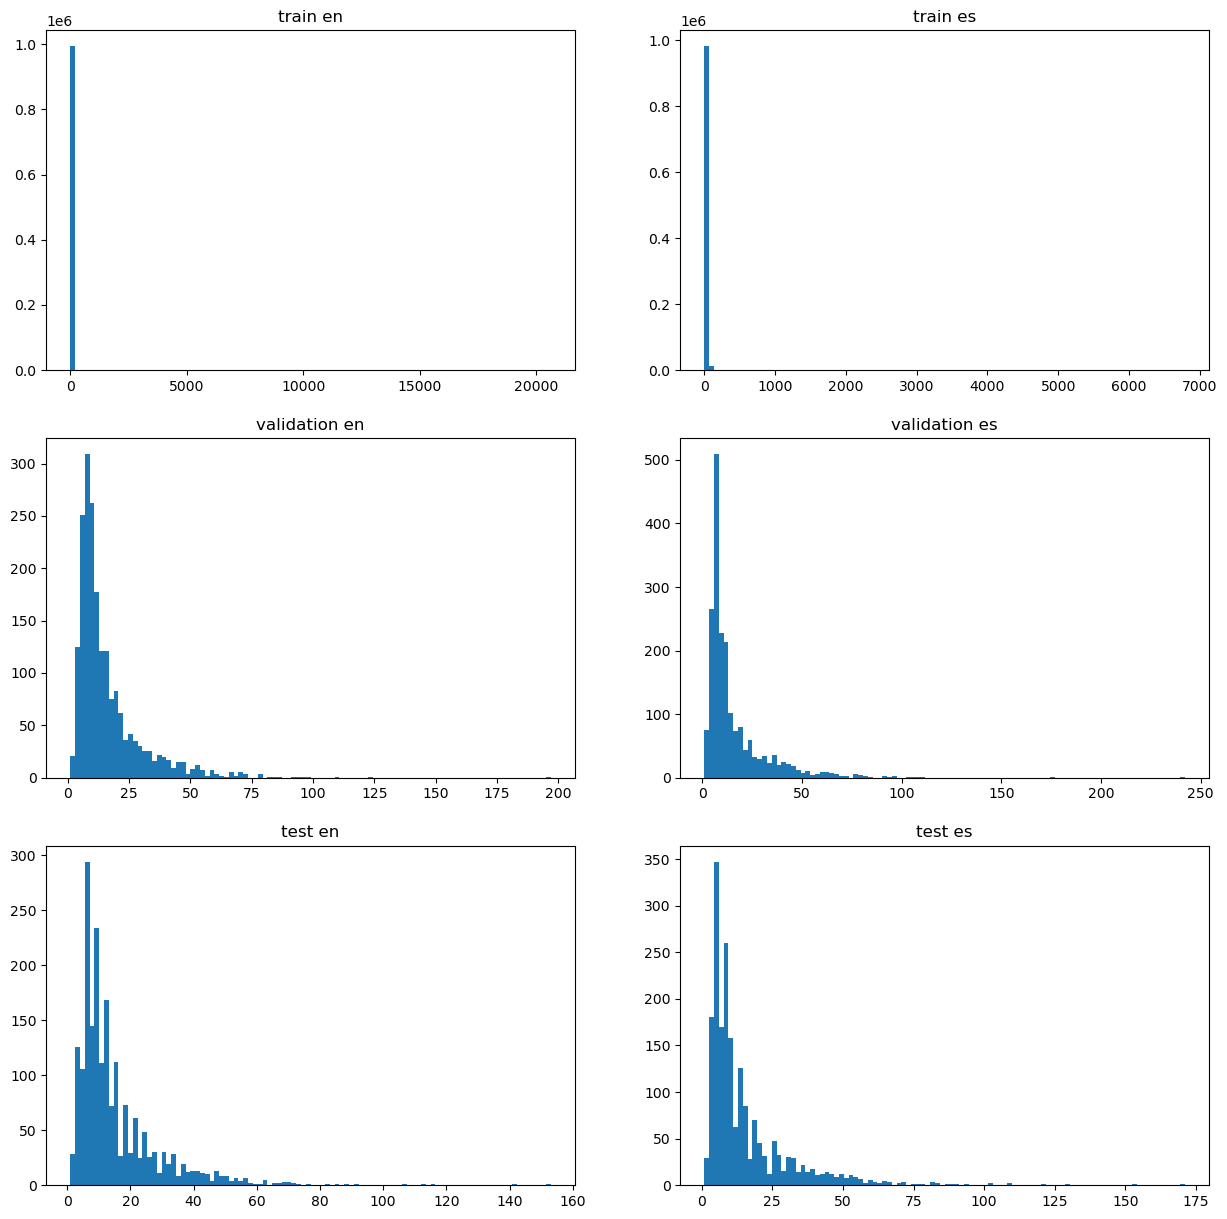

In [37]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Podemos ver que la mayoría de tamaños de las secuancias están agrupadas al inicio, es decir, no hay muchas secuencias muy largas

Vamos a ver los tamaños más grande del conjunto de entrenamiento en inglés

In [38]:
sentence_lengths_train_en_sorted = np.sort(sentence_lengths_train_en)
sentence_lengths_train_en_sorted[-10:]

array([  703,   732,   761,   793,   912,   974,  1266,  1276,  1957,
       20611])

Vemos que la secuencia más grande tiene un tamaño de 20611 tokens, pero la siguiente más grande tiene 1957 tokens

Vamos a ver cómo es la secuencia más larga del conjunto de entrenamiento en inglés

In [39]:
idx = int(np.where(sentence_lengths_train_en == sentence_lengths_train_en_sorted[-1])[0])
sentence_en = opus100_train_cleaned[idx]["translation"]["en"]
encode_sentence_en = tokenizer_source.encode(sentence_en).ids
sentence_es = opus100_train_cleaned[idx]["translation"]["es"]
encode_sentence_es = tokenizer_target.encode(sentence_es).ids
print(len(encode_sentence_en), sentence_en)
print(len(encode_sentence_es), sentence_es)

20611 Fifty-ninth session * A/59/50 and Corr.1. Item 118 of the preliminary list* Joint Inspection Unit Report of the Joint Inspection Unit on the evaluation of the United Nations Volunteers Programme Note by the Secretary-General The Secretary-General has the honour to transmit to the members of the General Assembly the report of the Joint Inspection Unit entitled “Evaluation of the United Nations Volunteers Programme” (JIU/REP/2003/7). Prepared by Armando Duque González Joint Inspection Unit Geneva ALD appointment of limited duration CIS Commonwealth of Independent States CIVICUS World Alliance for Citizen Participation CMT Core Management Team DPKO Department of Peacekeeping Operations ERP Enterprise Resource Planning FAO Food and Agriculture Organization of the United Nations IAVE International Association for Voluntary Effort IBFL International Business Leader Forum ICSC International Civil Service Commission IFRC International Federation of Red Cross and Red Crescent Societies IL

Tiene pinta de ser una cita en la que solo se ha traducido lo importante

Vamos a hacer lo mismo con las secuencias de entrenamiento en español, primero vamos las más largas

In [40]:
sentence_lengths_train_es_sorted = np.sort(sentence_lengths_train_es)
sentence_lengths_train_es_sorted[-10:]

array([ 695,  796,  825,  912, 1152, 1282, 1283, 1464, 1960, 6788])

Al igual que antes vemos que la más larga es mucho más larga que la anterior. Vemos la secuencia más larga en español

In [43]:
idx = int(np.where(sentence_lengths_train_es == sentence_lengths_train_es_sorted[-1])[0])
sentence_en = opus100_train_cleaned[idx]["translation"]["en"]
encode_sentence_en = tokenizer_source.encode(sentence_en).ids
sentence_es = opus100_train_cleaned[idx]["translation"]["es"]
encode_sentence_es = tokenizer_target.encode(sentence_es).ids
print(len(encode_sentence_en), sentence_en)
print(len(encode_sentence_es), sentence_es)

262 Fifty-eighth session Agenda item 44 Culture of peace Letter dated 31 October 2003 from the Chargé d'affaires a.i. of the Permanent Mission of Indonesia to the United Nations addressed to the President of the General Assembly I have the honour, on behalf of the member countries of the Association of South-East Asian Nations (ASEAN), namely, Brunei Darussalam, Cambodia, Indonesia, the Lao People's Democratic Republic, Malaysia, Myanmar, the Philippines, Singapore, Thailand and Viet Nam, to forward herewith copies of: (a) The Declaration of ASEAN Concord II (Bali Concord II) (see annex I); (b) A press statement issued by the Chairperson of the Ninth ASEAN Summit and the Seventh ASEAN Plus Three Summit (see annex II). As you may be aware, those documents were issued at the Ninth ASEAN Summit, which was convened in Bali, Indonesia, on 7 and 8 October 2003. In this regard, I have the further honour to kindly request that the present letter and its annexes be circulated as a document of t

Al igual que antes, parece una cita en la que solo se ha traducido lo importante

Vamos a ver las longitudes máximas si nos quedamos con el 99% de las secuencias más cortas, es decir, casi todas

In [44]:
percentage = 0.99
sentence_lengths_train_en_sorted = np.sort(sentence_lengths_train_en)
sentence_lengths_train_en_sorted = sentence_lengths_train_en_sorted[:int(len(sentence_lengths_train_en_sorted)*percentage)]
sentence_lengths_train_en_sorted[-10:]

array([67, 67, 67, 67, 67, 67, 67, 67, 67, 67])

En el 99% del dataset de entrenamiento en inglés tiene una longitud máxima de 67 tokens

In [45]:
percentage = 0.99
sentence_lengths_train_es_sorted = np.sort(sentence_lengths_train_es)
sentence_lengths_train_es_sorted = sentence_lengths_train_es_sorted[:int(len(sentence_lengths_train_es_sorted)*percentage)]
sentence_lengths_train_es_sorted[-10:]

array([73, 73, 73, 73, 73, 73, 73, 73, 73, 73])

Mientras que el 99% del dataset de entrenamiento en español tiene una longitud máxima de 73 tokens

Así que definimos la longitud máxima de secuencia como el máximo de de estas dos longitudes

In [46]:
max_sequence_len = int(np.max([int(sentence_lengths_train_en_sorted[-1]), int(sentence_lengths_train_es_sorted[-1])]))
max_sequence_len

73

## Guardar los datos limpiados

Creamos un nuevo dataset eliminando las secuencias con más de 104 tokens

In [48]:
opus100_train_croped = opus100_train_cleaned.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)
opus100_val_croped = opus100_val_cleaned.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)
opus100_test_croped = opus100_test_cleaned.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)

Filter:   0%|          | 0/993255 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1987 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1976 [00:00<?, ? examples/s]

In [49]:
print(f"len dataset train: {len(opus100_train_croped)}, se han eliminado {len(opus100_train) - len(opus100_train_croped)} ejemplos")
print(f"len dataset validation: {len(opus100_val_croped)}, se han eliminado {len(opus100_val) - len(opus100_val_croped)} ejemplos")
print(f"len dataset test: {len(opus100_test_croped)}, se han eliminado {len(opus100_test) - len(opus100_test_croped)} ejemplos")
print(f"En total se han eliminado {len(opus100_train) + len(opus100_val) + len(opus100_test) - len(opus100_train_croped) - len(opus100_val_croped) - len(opus100_test_croped)} ejemplos")

len dataset train: 982560, se han eliminado 17440 ejemplos
len dataset validation: 1963, se han eliminado 37 ejemplos
len dataset test: 1955, se han eliminado 45 ejemplos
En total se han eliminado 17522 ejemplos


Vemos que haciendo esto perdemos unas 17000 sentencias en total, pero aún así tenemos muchas sentencias

Volvemos a dibujar el histograma del dataset recortado

In [50]:
sentence_lengths_train_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_train_croped])
sentence_lengths_train_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_train_croped])

sentence_lengths_validation_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_val_croped])
sentence_lengths_validation_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_val_croped])

sentence_lengths_test_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_test_croped])
sentence_lengths_test_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_test_croped])

Text(0.5, 1.0, 'test es')

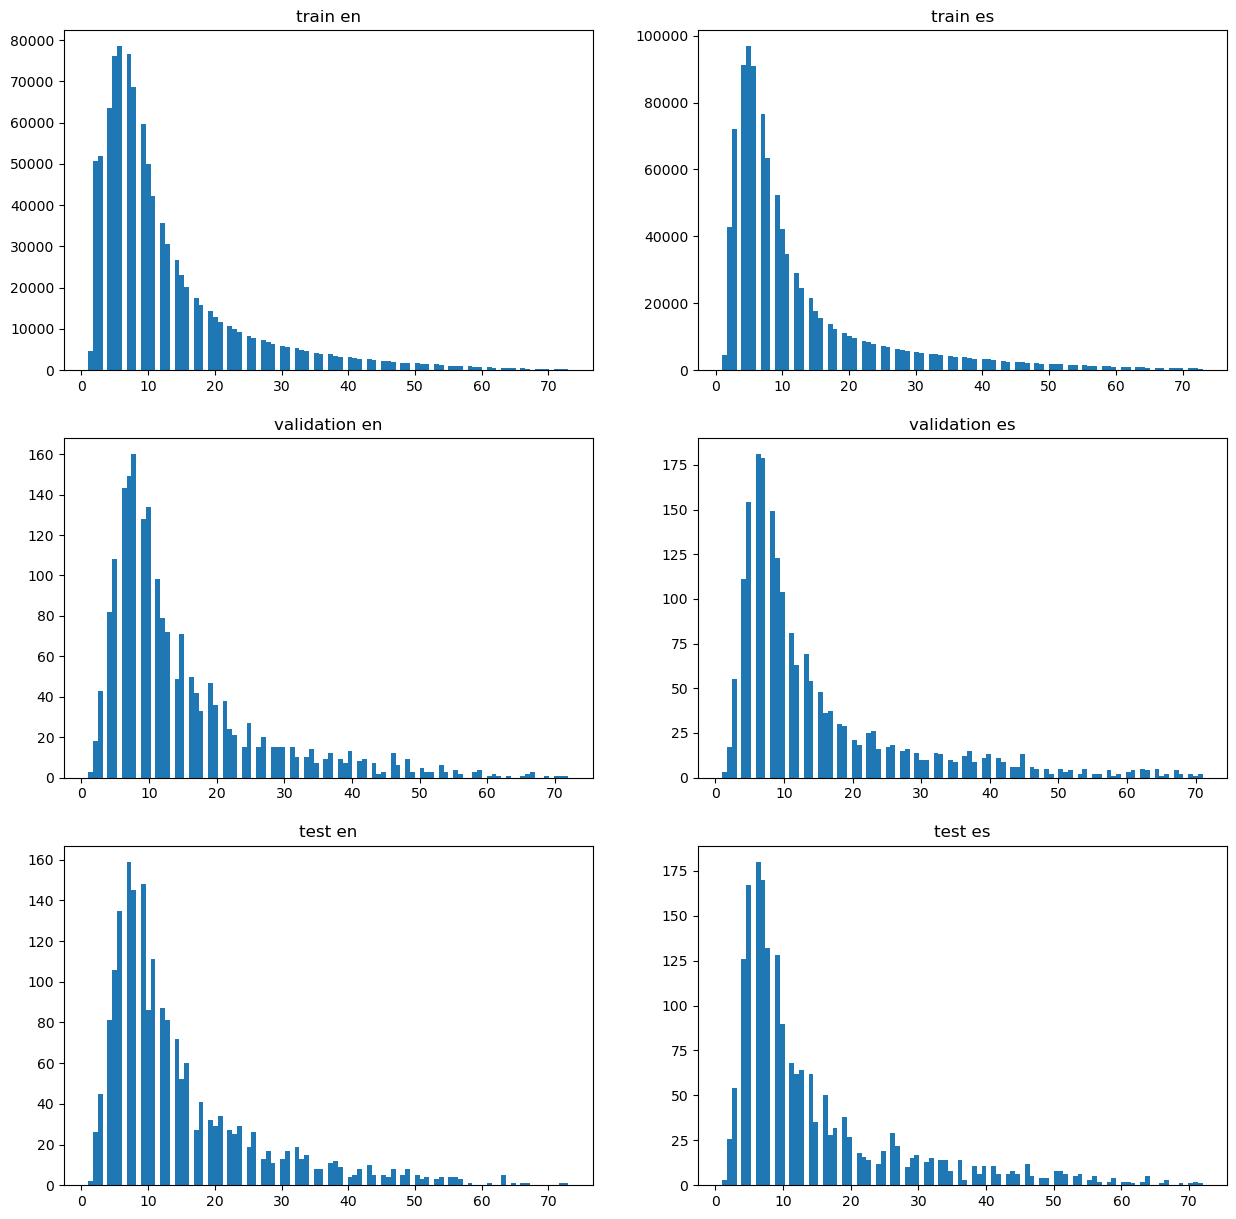

In [51]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos el dataset limpiado para usarlo durante el entrenamiento

In [52]:
import os

path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_train_croped.save_to_disk(f"{path}/opus100_train_croped")
opus100_val_croped.save_to_disk(f"{path}/opus100_val_croped")
opus100_test_croped.save_to_disk(f"{path}/opus100_test_croped")

Saving the dataset (0/1 shards):   0%|          | 0/982560 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1963 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1955 [00:00<?, ? examples/s]

Podemos ver que casi todas las secuencias tienen 20 tokens o menos, por lo que vamos a crearnos otro dataset con todas las secuencias que tengan 20 tokens o menos, para que si durante el entrenamiento no tenemos una buena GPU podemos usar este dataset que ocupará menos memoria de la GPU

In [53]:
max_sequence_len = 20
opus100_train_croped_20 = opus100_train_croped.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)
opus100_val_croped_20 = opus100_val_croped.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)
opus100_test_croped_20 = opus100_test_croped.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) <= max_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) <= max_sequence_len)

Filter:   0%|          | 0/982560 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1963 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1955 [00:00<?, ? examples/s]

In [54]:
print(f"len dataset train: {len(opus100_train_croped_20)}, se han eliminado {len(opus100_train) - len(opus100_train_croped_20)} ejemplos")
print(f"len dataset validation: {len(opus100_val_croped_20)}, se han eliminado {len(opus100_val) - len(opus100_val_croped_20)} ejemplos")
print(f"len dataset test: {len(opus100_test_croped_20)}, se han eliminado {len(opus100_test) - len(opus100_test_croped_20)} ejemplos")
print(f"En total se han eliminado {len(opus100_train) + len(opus100_val) + len(opus100_test) - len(opus100_train_croped_20) - len(opus100_val_croped_20) - len(opus100_test_croped_20)} ejemplos")

len dataset train: 800781, se han eliminado 199219 ejemplos
len dataset validation: 1489, se han eliminado 511 ejemplos
len dataset test: 1485, se han eliminado 515 ejemplos
En total se han eliminado 200245 ejemplos


Aquí se han perdido casi un cuarto de las frases, pero aun así seguimos teniendo muchas y vamos a poder usar GPUs menos potentes

Volvemos a ver el histograma

In [55]:
sentence_lengths_train_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_train_croped_20])
sentence_lengths_train_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_train_croped_20])

sentence_lengths_validation_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_val_croped_20])
sentence_lengths_validation_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_val_croped_20])

sentence_lengths_test_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_test_croped_20])
sentence_lengths_test_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_test_croped_20])

Text(0.5, 1.0, 'test es')

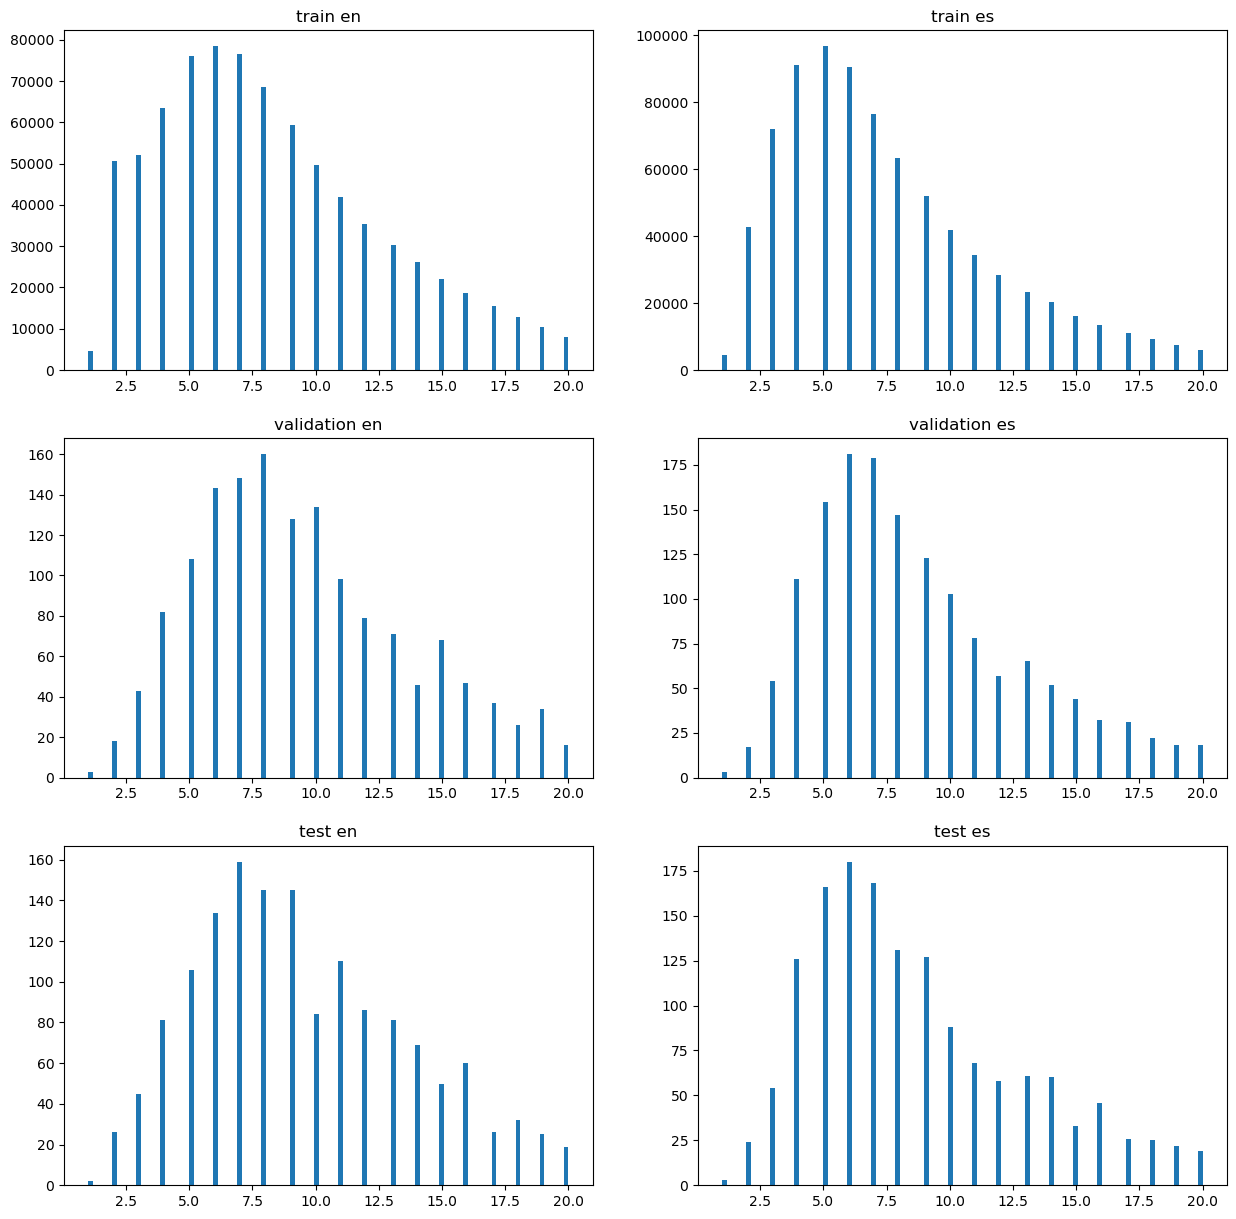

In [56]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos este dataset también por si se quiere usar

In [57]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_train_croped_20.save_to_disk(f"{path}/opus100_train_croped_20")
opus100_val_croped_20.save_to_disk(f"{path}/opus100_val_croped_20")
opus100_test_croped_20.save_to_disk(f"{path}/opus100_test_croped_20")

Saving the dataset (0/1 shards):   0%|          | 0/800781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1489 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1485 [00:00<?, ? examples/s]

Vamos a ver las sentencias más cortas

In [61]:
sentence_lengths_train_en_sorted = np.sort(sentence_lengths_train_en)
sentence_lengths_train_en_sorted[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [105]:
idx = int(np.where(sentence_lengths_train_en == sentence_lengths_train_en_sorted[0])[0][0])
sentence_en = opus100_train_croped_20[idx]["translation"]["en"]
encode_sentence_en = tokenizer_source.encode(sentence_en).ids
sentence_es = opus100_train_croped_20[idx]["translation"]["es"]
encode_sentence_es = tokenizer_target.encode(sentence_es).ids
print(len(encode_sentence_en), sentence_en)
print(len(encode_sentence_es), sentence_es)

1 Eritrea
1 Eritrea


Cuando tenemos frases muy cortas no van a ayudar al entrenamiento del modelo, por lo que vamos a eliminar las más cortas. Vamos a ver frases con pocos tokens

In [132]:
for i in range(1,10):
    # Get position of sentence_lengths_train_en_sorted where the length is equal to i
    idx_min_len = np.where(sentence_lengths_train_en_sorted == i)[0][0]

    # Get position of sentence_lengths_train_en where sentence_lengths_train_en is equal to sentence_lengths_train_en_sorted[idx_min_len]
    idx = int(np.where(sentence_lengths_train_en == sentence_lengths_train_en_sorted[idx_min_len])[0][0])

    # Get length and sentences of source and target
    sentence_en = opus100_train_croped_20[idx]["translation"]["en"]
    encode_sentence_en = tokenizer_source.encode(sentence_en).ids
    sentence_es = opus100_train_croped_20[idx]["translation"]["es"]
    encode_sentence_es = tokenizer_target.encode(sentence_es).ids

    print(len(encode_sentence_en), sentence_en)
    print(len(encode_sentence_es), sentence_es)
    print("")

1 Eritrea
1 Eritrea

2 Norman.
2 Norman.

3 Fuck this!
5 ¡Por la mierda!

4 - Come on.
3 - Vamos.

5 It's uncomplicated.
5 Es algo sin complicaciones.

6 You have to help me.
3 Debes ayudarme.

7 I'm out of here.
5 Me voy de aquí.

8 Now pivot as you deliver the stroke.
7 Ahora gira mientras propinas el golpe.

9 - Oh, have fun scrubbing my boxers.
4 - ¿Qué?



Podemos quedarnos con las frases que tengan más de 3 tokens

Creamos otro dataset, pero ahora con una longitud máxima de 20 tokens y una longitud mínima de 3 tokens

In [141]:
min_sequence_len = 3
opus100_train_croped_3_20 = opus100_train_croped_20.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) >= min_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) >= min_sequence_len)
opus100_val_croped_3_20 = opus100_val_croped_20.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) >= min_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) >= min_sequence_len)
opus100_test_croped_3_20 = opus100_test_croped_20.filter(lambda example: len(tokenizer_source.encode(example["translation"]["en"]).ids) >= min_sequence_len and len(tokenizer_target.encode(example["translation"]["es"]).ids) >= min_sequence_len)


Filter:   0%|          | 0/800781 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1489 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1485 [00:00<?, ? examples/s]

In [142]:
print(f"len dataset train: {len(opus100_train_croped_3_20)}, se han eliminado {len(opus100_train) - len(opus100_train_croped_3_20)} ejemplos")
print(f"len dataset validation: {len(opus100_val_croped_3_20)}, se han eliminado {len(opus100_val) - len(opus100_val_croped_3_20)} ejemplos")
print(f"len dataset test: {len(opus100_test_croped_3_20)}, se han eliminado {len(opus100_test) - len(opus100_test_croped_3_20)} ejemplos")
print(f"En total se han eliminado {len(opus100_train) + len(opus100_val) + len(opus100_test) - len(opus100_train_croped_3_20) - len(opus100_val_croped_3_20) - len(opus100_test_croped_3_20)} ejemplos")

len dataset train: 728561, se han eliminado 271439 ejemplos
len dataset validation: 1458, se han eliminado 542 ejemplos
len dataset test: 1444, se han eliminado 556 ejemplos
En total se han eliminado 272537 ejemplos


No se han eliminado muchas más frases que antes, pero vamos a tener un mejor dataset

Volvemos a ver el histograma

In [143]:
sentence_lengths_train_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_train_croped_3_20])
sentence_lengths_train_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_train_croped_3_20])

sentence_lengths_validation_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_val_croped_3_20])
sentence_lengths_validation_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_val_croped_3_20])

sentence_lengths_test_en = np.array([len(tokenizer_target.encode(example["translation"]["en"]).ids) for example in opus100_test_croped_3_20])
sentence_lengths_test_es = np.array([len(tokenizer_source.encode(example["translation"]["es"]).ids) for example in opus100_test_croped_3_20])

Text(0.5, 1.0, 'test es')

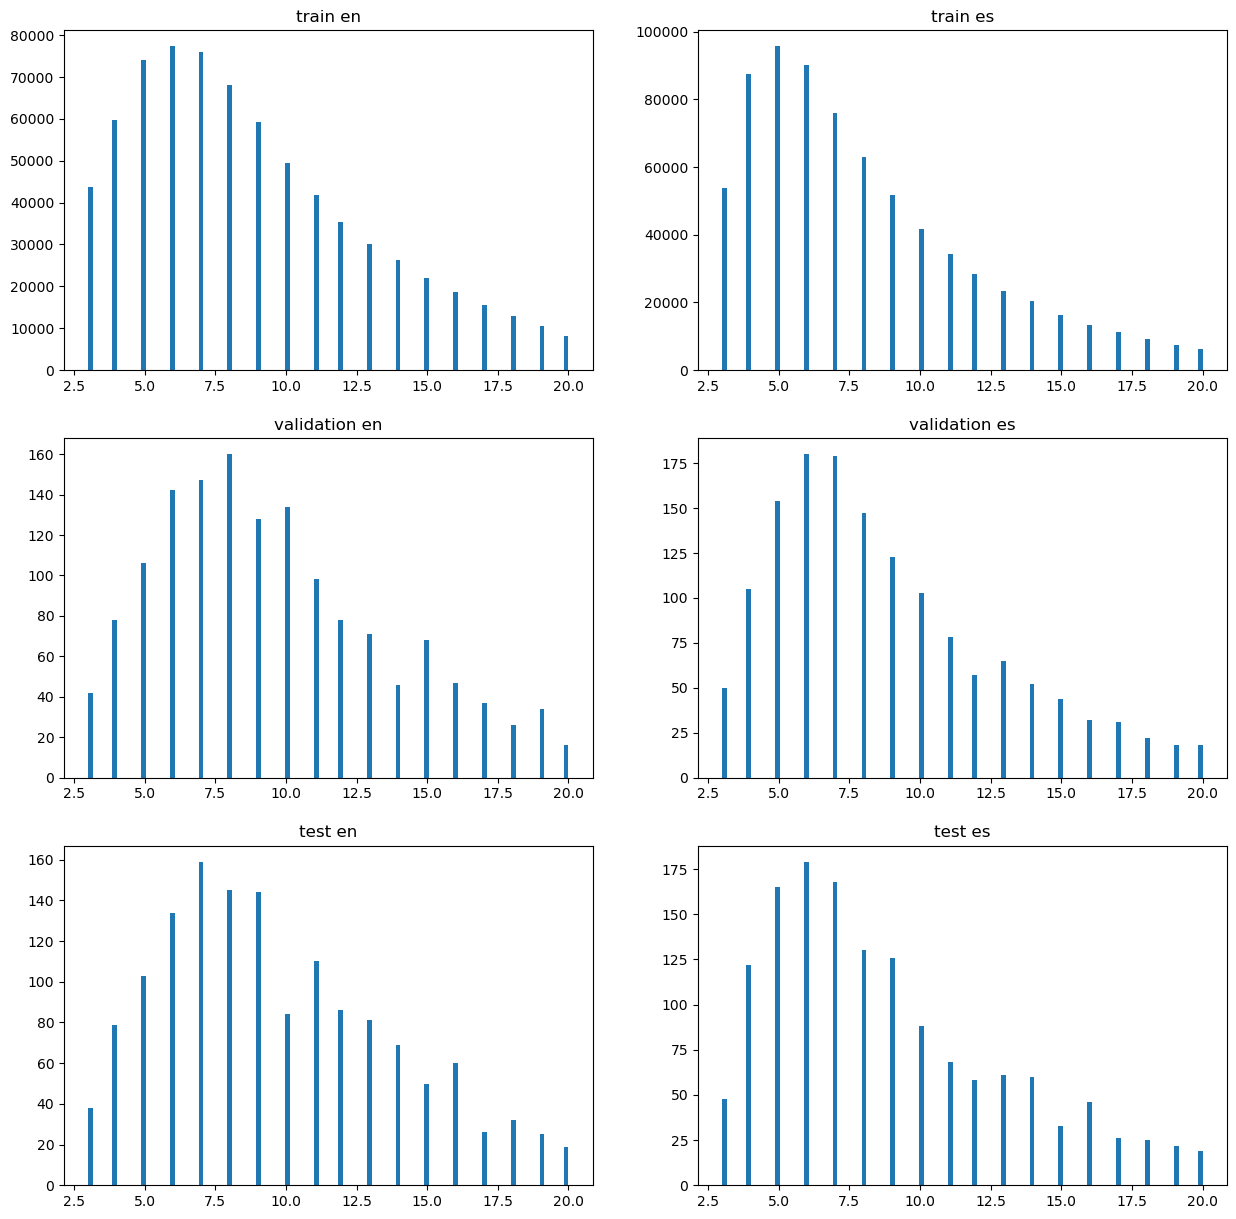

In [144]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].hist(sentence_lengths_train_en, bins=100)
axs[0, 0].set_title('train en')
axs[0, 1].hist(sentence_lengths_train_es, bins=100)
axs[0, 1].set_title('train es')
axs[1, 0].hist(sentence_lengths_validation_en, bins=100)
axs[1, 0].set_title('validation en')
axs[1, 1].hist(sentence_lengths_validation_es, bins=100)
axs[1, 1].set_title('validation es')
axs[2, 0].hist(sentence_lengths_test_en, bins=100)
axs[2, 0].set_title('test en')
axs[2, 1].hist(sentence_lengths_test_es, bins=100)
axs[2, 1].set_title('test es')

Guardamos este dataset también por si se quiere usar

In [145]:
path = "data"
if not os.path.exists(path):
    os.makedirs(path)
opus100_train_croped_3_20.save_to_disk(f"{path}/opus100_train_croped_3_20")
opus100_val_croped_3_20.save_to_disk(f"{path}/opus100_val_croped_3_20")
opus100_test_croped_3_20.save_to_disk(f"{path}/opus100_test_croped_3_20")

Saving the dataset (0/1 shards):   0%|          | 0/728561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1458 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1444 [00:00<?, ? examples/s]